In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

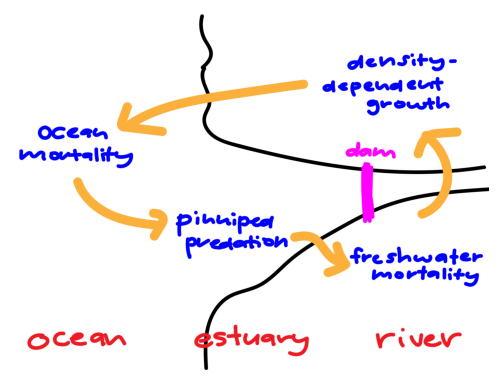

In [90]:
img = mpimg.imread("img/dynamics_diagram-01.png")
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [79]:
# get parameters
params = {
    "growth_L_r": 0.5, # lamprey intrinsic rate of growth
    "growth_L_K": 1000000, # lamprey carrying capacity
    "growth_S_r": 0.3, # salmon intrinsic rate of growth
    "growth_S_K": 1000000, # salmon carrying capacity
    "growth_sd": 10000, # variation in population growth
    "ocean_dd_L": 0.00001, # lamprey ocean survival (function of salmon density)
    "ocean_dd_S": 3000000, # salmon ocean survival (function of lamprey density)
    "ocean_surv1": 10, # beta dist. parameter for shared density-independent ocean survival
    "ocean_surv2": 1, # beta dist. parameter for shared density-independent ocean survival
    "pred_m": [1, 1], # prey switching exponents [lamprey, salmon], 1 = no switching
    "pred_c": [0.5, 0.1], # prey attack rate [lamprey, salmon]
    "pred_p": 0.3, # strength of predator density-dependence
    "pred_h": 0.1, # predator handling time
    "P": 300, # mean pinniped abundance
    "mortality": [0.3, 0.1] # spawner mortality [lamprey, salmon]
} 

### density-dependent growth

In [80]:
# density dependent growth
def growth(params, L, S):
    
    # logistic growth
    Lplus = (
        L * np.exp(params["growth_L_r"] * (1 - L / params["growth_L_K"])) + 
        np.random.normal(0, params["growth_sd"]) # growth error
    )
    Splus = (
        S * np.exp(params["growth_S_r"] * (1 - S / params["growth_S_K"])) +
        np.random.normal(0, params["growth_sd"]) # growth error
    )
    
    return [max(Lplus, 0), max(Splus, 0)]

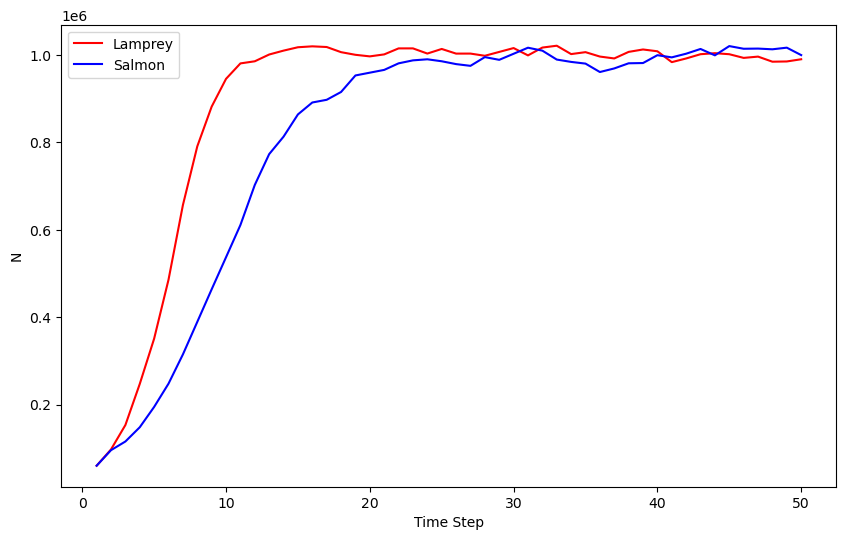

In [81]:
# plot

# create df
df = pd.DataFrame(np.nan, index=range(50), columns=['L', 'S'])

# Set initial values for the first row
df.iloc[0] = [60000, 60000]

# growth
for i in range(1, len(df)):
    smolts = growth(params, df.iloc[i-1, 0], df.iloc[i-1, 1])
    df.iloc[i, 0] = smolts[0] 
    df.iloc[i, 1] = smolts[1] 

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), df['L'], color='red', label='Lamprey')
plt.plot(range(1, 51), df['S'], color='blue', label='Salmon')
plt.xlabel('Time Step')
plt.ylabel('N')
plt.legend()
plt.show()

### ocean survival

In [69]:
# ocean survival
def ocean(params, L, S):
    # get ocean survival
    surv = np.random.beta(params["ocean_surv1"], params["ocean_surv2"])
    
    # L and S density-dependent survival interaction
    Lplus = L * (1 - np.exp(-params["ocean_dd_L"] * (S+1e-6))) * surv
    Splus = S * (1 - np.exp(-params["ocean_dd_S"] / (L+1e-6))) * surv
    
    return [Lplus, Splus]

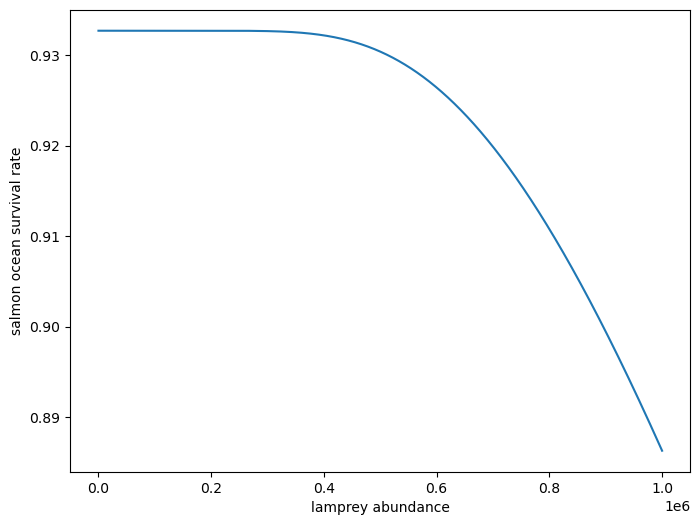

In [70]:
# salmon ocean survival as a function of lamprey abundance

# generate a density-indendent survival rate from a beta distribution
surv = np.random.beta(params["ocean_surv1"], params["ocean_surv2"])

# lamprey density
L = np.arange(1, params["growth_L_K"] + 1, 100)

# get overall salmon survival rate
y = (1 - np.exp(-params["ocean_dd_S"] / L)) * surv

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(L, y)
plt.xlabel("lamprey abundance")
plt.ylabel("salmon ocean survival rate")
plt.show()

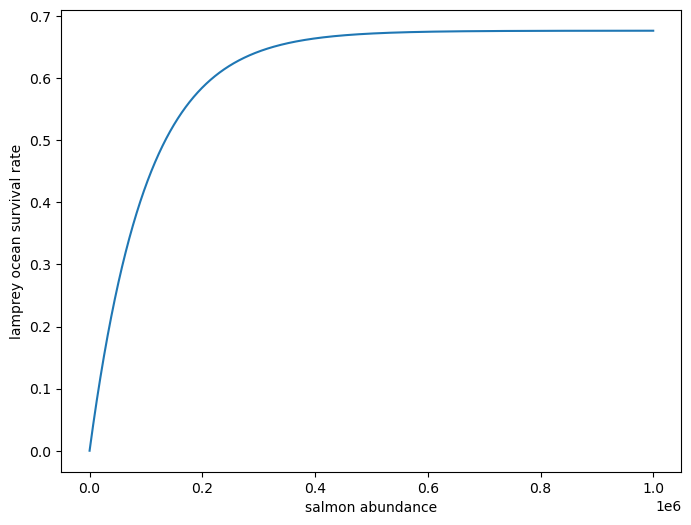

In [71]:
# lamprey ocean survival as a function of salmon abundance

# generate a density-indendent survival rate from a beta distribution
surv = np.random.beta(params["ocean_surv1"], params["ocean_surv2"])

# salmon density
S = np.arange(1, params["growth_S_K"] + 1, 100)

# get overall salmon survival rate
y = (1 - np.exp(-params["ocean_dd_L"] * S)) * surv

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(L, y)
plt.xlabel("salmon abundance")
plt.ylabel("lamprey ocean survival rate")
plt.show()

### estuary predation

In [82]:
# estuary predation 
def predation(params, L, S, P):
    x = np.array([L, S])
    
    # Calculate the denominator
    denominator = (
        P ** params["pred_p"] + params["pred_h"] * np.sum(params["pred_c"] * x ** params["pred_m"])
    )
    
    # get L and S prey per predator
    L_prey = params["pred_c"][0] * L ** params["pred_m"][0] / denominator
    S_prey = params["pred_c"][1] * S ** params["pred_m"][1] / denominator
    
    return [L_prey, S_prey]

In [85]:
# per pinniped predation rate
predation(params, L = 10000, S = 500000, P = 300)

[np.float64(0.9081769134078288), np.float64(9.081769134078288)]

### combine everything!

In [72]:
# add an action space
A = [
    0, # lamprey spawner mortality reduction
    0 # pinniped culling rate
]

In [73]:
# full step function
def step(params, L, S, action):
    
    # Spawner mortality
    L_mort = max(0, params["mortality"][0] - action[0]) # altered lamprey survival
    Lplus = np.random.binomial(n=round(L), p = 1 - L_mort)
    Splus = np.random.binomial(n=round(S), p = 1 - params["mortality"][1])
    
    # density-dependent reproduction
    smolts = growth(params, Lplus, Splus)
    
    # ocean mortality
    returns = ocean(params, smolts[0], smolts[1])
    
    # get number of pinnipeds (treated as an exogenous force)
    P = np.random.poisson(params["P"])
    P *= (1 - action[1]) # altered pinniped abundance

    # get consumed prey per predator
    consumed = np.array(predation(params, returns[0], returns[1], P)) * P

    # get final numbers of spawners to system
    spawners_L = returns[0] - consumed[0]
    spawners_S = returns[1] - consumed[1]
    
    # Return the final spawner values
    return [spawners_L, spawners_S]

In [74]:
# iterate
# create empty df
df = pd.DataFrame(np.nan, index=range(50), columns=['L', 'S'])

# set initial values for the first row
df.iloc[0] = [
    60000, # lamprey
    500000 # salmon
]

# Loop to populate the df using the step function
for i in range(1, len(df)):
    df.iloc[i, 0], df.iloc[i, 1] = step(params, df.iloc[i-1, 0], df.iloc[i-1, 1], A)

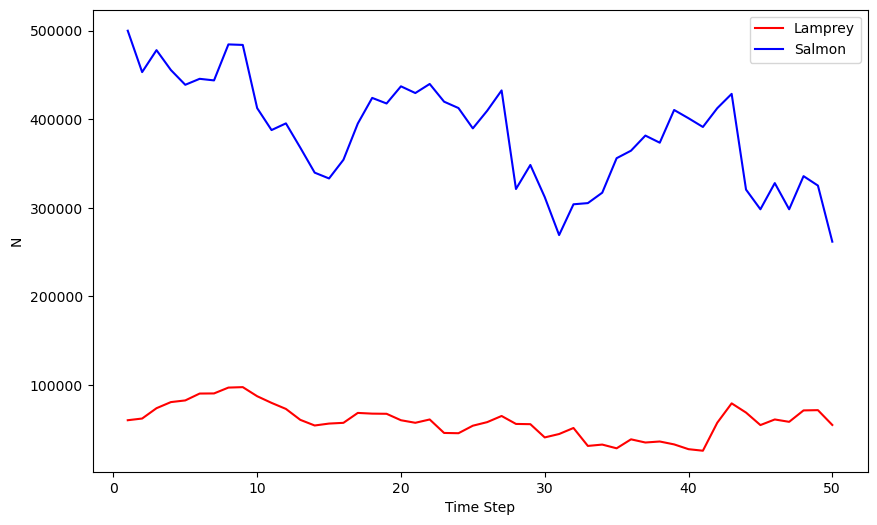

In [75]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), df['L'], color='red', label='Lamprey')
plt.plot(range(1, 51), df['S'], color='blue', label='Salmon')
plt.xlabel('Time Step')
plt.ylabel('N')
plt.legend()
plt.show()

In [76]:
# now decrease lamprey mortality
A = [
    0.1, # lamprey spawner mortality reduction
    0 # pinniped culling rate
]

df = pd.DataFrame(np.nan, index=range(50), columns=['L', 'S'])

# set initial values for the first row
df.iloc[0] = [
    60000, # lamprey
    500000 # salmon
]

# Loop to populate the df using the step function
for i in range(1, len(df)):
    df.iloc[i, 0], df.iloc[i, 1] = step(params, df.iloc[i-1, 0], df.iloc[i-1, 1], A)

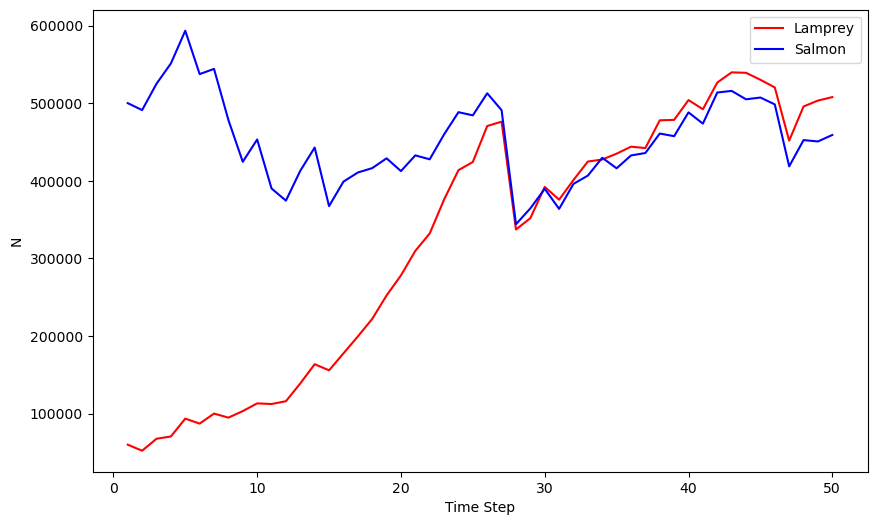

In [77]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), df['L'], color='red', label='Lamprey')
plt.plot(range(1, 51), df['S'], color='blue', label='Salmon')
plt.xlabel('Time Step')
plt.ylabel('N')
plt.legend()
plt.show()